For frequency to pitch mapping, consult, https://en.wikipedia.org/wiki/Piano_key_frequencies

In [21]:
from __future__ import print_function, division

import thinkdsp
import thinkplot

import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%matplotlib inline
PI2 = np.pi * 2

## Load key – freq. mapping
http://ada.evergreen.edu/~arunc/intro_doc/node12.htm

In [60]:
with open('key_freq_mapping') as f:
    lines = f.read().splitlines()
kf_map = { float(l.split()[1]):l.split()[0] for l in lines}

KEYS = list(kf_map.values())
FREQS = np.array(list(kf_map.keys()))

In [56]:
# Load octave 3 of organ
organ_wave = thinkdsp.read_wave('data/octave-3.wav')

In [3]:
organ_wave.make_audio()

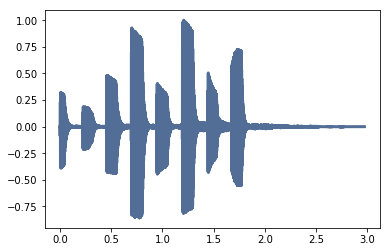

In [5]:
organ_wave.plot()

In [8]:
organ_wave.ts.shape, len(organ_wave.ts) / organ_wave.framerate

((131072,), 2.972154195011338)

In [9]:
organ_wave.duration

2.972154195011338

No handles with labels found to put in legend.


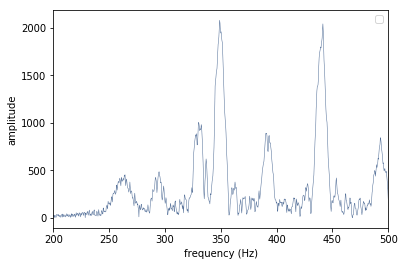

In [17]:
spectrum = organ_wave.make_spectrum()
spectrum.plot(linewidth=0.5)
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='amplitude',
                 xlim=[200, 500])
#                  xlim=[0, spectrum.fs[-1]])

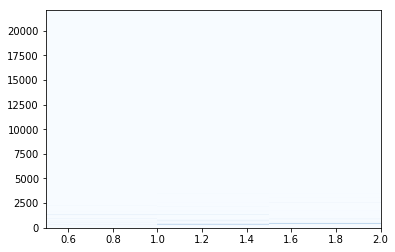

In [14]:
spectro = organ_wave.make_spectrogram(seg_length=organ_wave.framerate) 
spectro.plot(high=organ_wave.framerate/2)

In [ ]:
framerate = organ_wave.framerate  # 44100

## Load C key

No handles with labels found to put in legend.


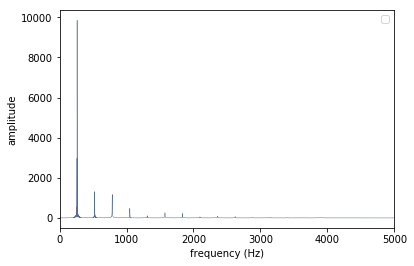

In [16]:
c_wave = thinkdsp.read_wave('data/c.wav')
display(c_wave.make_audio())

spectrum = c_wave.make_spectrum()
spectrum.plot(linewidth=0.5)
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='amplitude',
                 xlim=[0, 5000])

No handles with labels found to put in legend.


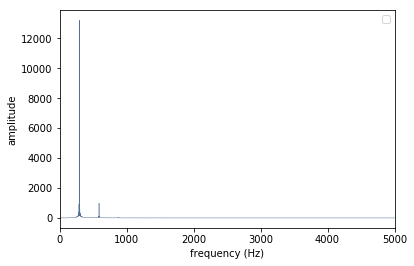

In [17]:
d_wave = thinkdsp.read_wave('data/d.wav')
display(d_wave.make_audio())

spectrum = d_wave.make_spectrum()
spectrum.plot(linewidth=0.5)
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='amplitude',
                 xlim=[0, 5000])

In [9]:
spectrum.amps.shape, spectrum.fs.shape

((65537,), (65537,))

In [27]:
c_amps = spectrum.amps.copy()

No handles with labels found to put in legend.


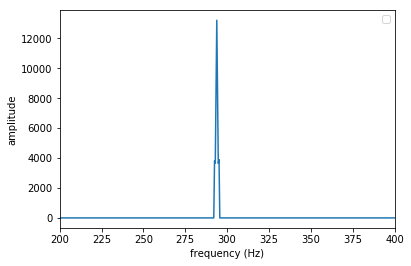

In [31]:
c_amps[c_amps < 2000] = 0

plt.plot(spectrum.fs, c_amps)
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='amplitude',
                 xlim=[200, 400])

In [35]:
spectrum.fs[spectrum.amps.argmax()]

293.8385009765625

## Bulk load keys and inspect pitch

In [69]:
def freq_to_key(freq):
    return kf_map[FREQS[np.argmin(np.abs(FREQS - freq))]]

keys = ('c', 'd', 'e', 'f', 'g', 'a', 'b', 'c4')

for key in keys:
    wave = thinkdsp.read_wave(f'data/{key}.wav')
    spectrum = wave.make_spectrum()
    print(key, freq_to_key(spectrum.fs[spectrum.amps.argmax()]), spectrum.fs[spectrum.amps.argmax()])

c c3 262.0994567871094
d d3 293.8385009765625
e e3 330.17578125
f f3 349.017333984375
g g3 391.6351318359375
a a4 440.0848388671875
b b4 492.572021484375
c4 c4 523.077392578125
